# EDA Of the Global Wheat Detection Challenge

### Goals

* Perform EDA to understand the data
* Follow regular step structure of EDA

### Comments

TODO
* Map tables to pandas dataframes


In [ ]:
!  apt-get install tree

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk", font_scale=1.4)
sns.set_style("whitegrid")
# sns.set_palette(‘CMRmap’)

! apt-get install tree

## Step 1: Goal

Estimate the number and size of wheat heads. The model must generalize from the training regions in Europe and NA to the areas of the test set in Australia, Japan China. The competition will run on the Kaggle platform from 4th May to 4th August 2020.  

Challenges:
* different growing conditions
* Different countries
* Current detection methods involve one- and two-stage detectors (Yolo-V3 and Faster-RCNN), but even when trained with a large dataset, a bias to the training region remains.
* Dataset is not exact in methods which could motivate augmentation
    *  height of the image acquisition ranges between 1.8 m and 3 m above theground.
    * camera focal length varies from 10to 50 mm with a range of sensor sizes
    * Thedifferences in camera setup lead to arange ofGround Sampling Distance (GSD) ranging from 0.10 to 0.62 mm with the half field of view along  the  image diagonal varying  from  10° to  46°.
    * Although all images were acquired at the nadir-viewing direction, some geometric distortion may be observed
    

Evaluation & Metrics:
* IoU of bounding boxes. The score returned by the competition metric is the mean taken over the individual average precisions of each image in the test dataset.
* Confidence score provided which help deciding which predictions to check first to match label


Competition: http://www.global-wheat.com/2020-challenge/




## Step 2: Extract the Data

Data provided by Kagge. Some description at http://www.global-wheat.com/data-description/


* According to Kaggle the test data includes about 1,000 images from Australia, Japan, and China.
* wheat heads from outdoor images of wheat plants, including wheat datasets from around the globe. 
* To better gauge the performance for unseen genotypes, environments, and observational conditions, the training dataset covers multiple regions. You will use more than 3,000 images from Europe (France, UK, Switzerland) and North America (Canada). The test data includes about 1,000 images from Australia, Japan, and China.
* Data is benchmark for wheat detection methods. Description in the paper https://arxiv.org/ftp/arxiv/papers/2005/2005.02162.pdf


* There is a row in train.csv for each bounding box.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break
    break

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

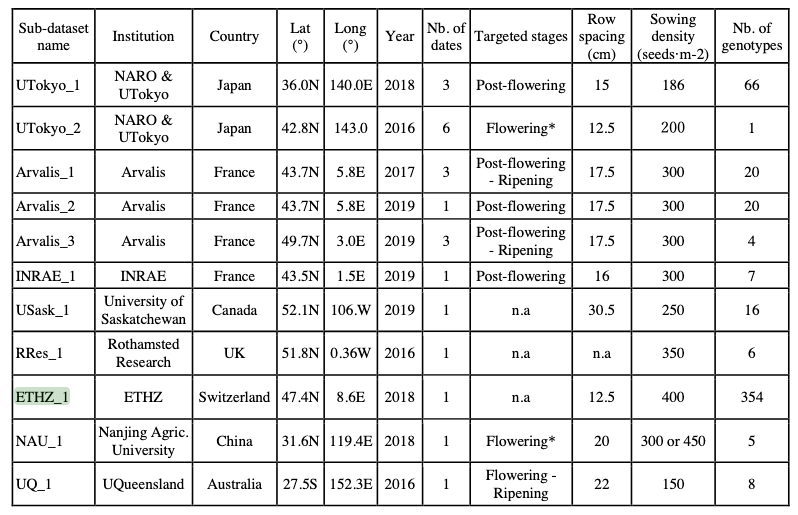

In [ ]:
columns  = ['source', 'Country', 'Lat', 'Long', 'Year', 'NB_date', 'stages', 'RowSpacing', 
            'SowingDensity', 'NBOfgenotypes']
subset_maps = {'UQ_1': ['Australia', '27.5S', '152.3E', '2016', '1', 'Flowering - Ripening', '22', '150', '8'], 
               'NAU_1': ['China', '31.6N', '119.4E', '2018', '1', 'Flowering', '20', '300 or 450', '5'],
               'ETHZ_1': ['Switzerland', '47.4', '8.6E', '2018', '1', 'na', '12.5', '400', '354'], 
               'RRes_1' : ['UK', '51.8N', '0.36W',  '2016', '1', 'na', 'na', '350', '6'],
               'USask_1' : ['Canada', '52.1N', '106.W', '2019', '1', 'na', '30.5', '250', '16'],
               'INRAE_1': ['France', '43.5N', '1.5E', '2019', '1', 'Post-flowering', '16', '300', '7'],
                'Arvalis_3' : ['France', '49.7N', '3.0E', '2019', '3', 'Post-flowering - Ripening', '17.5', '300', '4'],
                'Arvalis_2': ['France', '43.7N', '5.8E', '2019', '1', 'Post-flowering', '17.5', '300', '20'],
               'Arvalis_1' : ['France', '43.7N', '5.8E', '2017', '3', 'Post-flowering - Ripening', '17.5', '300', '20'],
                 'UTokyo_2' : ['Japan', '42.8N', '143.0', '2016', '6', 'Flowering', '12.5', '200', '1'],
                  'UTokyo_1': ['Japan', '36.0N', '140.0E', '2018', '3', 'Post-flowering', '15', '186', '66']}
subset_maps = dict((k.lower(), v) for k,v in subset_maps.items()) # lowercase keys
charact1 = pd.DataFrame.from_dict(subset_maps).T.reset_index()
charact1 = charact1.rename(columns={k:v for k,v in zip(charact1.columns, columns)})
charact1

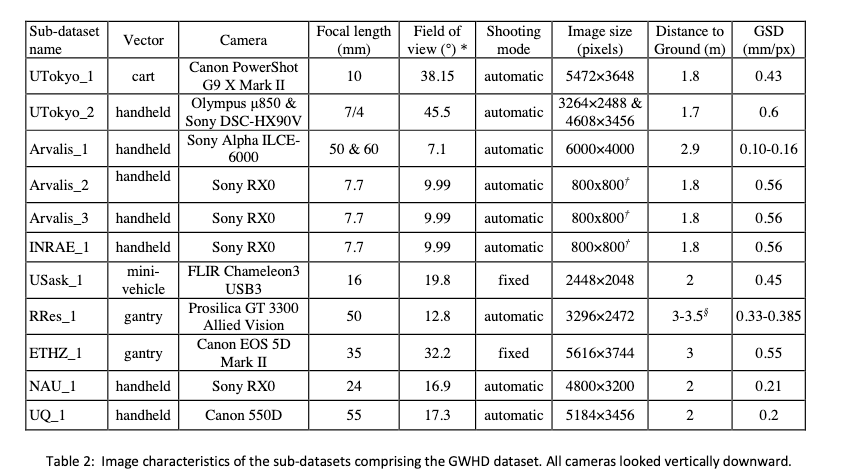

In [ ]:
subset_maps = {'UQ_1': 'Australia', 'NAU_1': 'China', 'ETHZ_1': 'Switzerland', 'RRes_1' : 'UK',
               'USask_1' : 'Canada', 'INRAE_1': 'France', 'Arvalis_3' : 'France', 'Arvalis_2': 'France',
               'Arvalis_1' : 'France', 'UTokyo_2' : 'Japan', 'UTokyo_1':'Japan'}
subset_maps = dict((k.lower(), v) for k,v in subset_maps.items()) # lowercase keys
len(subset_maps)

## Step 3: Meeting & Greet the Data

* There are only 10 test images.
* 147k bounding boxes
* We have a 2 image characteristics tables in the paper which require exploration

* Variable types
    * character: image_id, source
    * numberic discrete: width,height
    * bbox: list  of discrete numbers
    
* Which features may contain errors or typos?
    * source, cross-reference with publication table. No missing.
    * image_id, cross-reference with available .jpg data. No missing
* Which features contain blank, null or empty values?
    * No NaN values and no empty string missing values.
    
    
* Variables & Assumptions
    * image_id: unique hash value for image. each hash has one image available in the directory.
    * width, height: fixed size of all images. No need to include it as variables.
    * bbox: bounding box: pixels: [xmin, ymin, width, height] why are they continous and not discrete?
    * source: corresponds to the sub-dataset name in the paper. corresponds to region or time of country. 
    * other variables from the table from the paper above.


In [ ]:
! tree /kaggle/input/global-wheat-detection -L 1

In [ ]:
%%bash
ls /kaggle/input/global-wheat-detection/train | wc -l
ls /kaggle/input/global-wheat-detection/test | wc -l

In [ ]:
metadata = pd.read_csv("/kaggle/input/global-wheat-detection/train.csv")
metadata.shape

In [ ]:
metadata.head()

In [ ]:
metadata.sample(10, random_state=42)

In [ ]:
metadata.info()

In [ ]:
cat_cols = ['image_id', 'bbox', 'source']
num_cols = ['width', 'height']

### Missing values?

In [ ]:
for col in cat_cols:
    metadata[col] = metadata[col].replace('', np.nan)

In [ ]:
metadata.isna().sum()

In [ ]:
charact1.replace('na', np.nan, inplace=True)

### Features with errors?

In [ ]:
subset_maps.keys()

confirm that all subsets are correct from the paper

In [ ]:
metadata[~metadata['source'].isin(list(subset_maps.keys()))]

In [ ]:
from pathlib import Path


In [ ]:
image_names = [path.stem for path in Path('/kaggle/input/global-wheat-detection').rglob('*.jpg')]
image_paths = [path for path in Path('/kaggle/input/global-wheat-detection').rglob('*.jpg')]
len(image_names)

All bounding boxes have images available in train and test.

In [ ]:
(~metadata['image_id'].isin(image_names)).sum()

All images have corresponding files in the meta data csv file

In [ ]:
pd.DataFrame(image_names).isin(metadata['image_id']).sum()

In [ ]:
metadata['bbox'] = metadata['bbox'].apply(eval)

In [ ]:
(metadata['bbox'].apply(lambda lst: len(lst)) != 4).sum()

In [ ]:
metadata = metadata.drop(columns=['width', 'height'])

## Step 4: Data Distributions

* width/height: fixed values as expected
* image_id: indicate that most frequent has 116 wheat heads per image. That is a lot! outlier?
    *  thee distribution of peak heads per image peaks around 40 heads.
* source: most common country is swizerland. Contains the 4 countries


In [ ]:
tr_image_id = [path.stem for path in image_paths if 'train' in str(path)]
test_image_id = [path.stem for path in image_paths if 'test' in str(path)]

In [ ]:
test_image_id

In [ ]:
metadata_tr = metadata[metadata['image_id'].isin(tr_image_id)]
metadata_tr.shape

> For the test images no labels are available.

In [ ]:
metadata_test = metadata[metadata['image_id'].isin(test_image_id)]
metadata_test.shape

In [ ]:
metadata[num_cols].describe()

In [ ]:
# metadata[cat_cols].describe()

### Grouping by Region

In [ ]:
subset_maps

In [ ]:
metadata['source_name'] = metadata['source'].apply(lambda abbr: subset_maps[abbr])

As expected, the training data only contains the 4 countries. If possible, use relative numbers

In [ ]:
ax = metadata['source_name'].value_counts().div(metadata['source_name'].value_counts().sum()).plot(kind='bar', grid=True)
ax.set_ylabel('fraction of wheat heads')

In [ ]:
ax = metadata.drop_duplicates(subset=['image_id'])['source_name'].value_counts().plot(kind='bar', grid=True)
ax.set_ylabel('number of images')
_ = ax.set_yticks(np.arange(0, 2500, step=500))

How does the distribution looks like for sub-areas?

### Grouping of heads per image

In [ ]:
ax = metadata['image_id'].value_counts().plot(kind='hist', grid=True)
ax.set_xlabel('number of wheat heads')
ax.set_ylabel('wheat heads per image')

In [ ]:
image_heads_pop.reset_index?

Introduce business index for image based on 4 distribution quantiles.

In [ ]:
image_heads_pop, bin_edges = pd.qcut(metadata['image_id'].value_counts(), q=4, labels=False, retbins=True, precision=0)
bin_edges

In [ ]:
metadata = metadata.join(image_heads_pop, bboxe
metadata.rename(columns = {'image_id_heads_business': 'heads_business'}, inplace=True)

In [ ]:
metadata.head()

Every image contains at least one wheat head. No background images!

In [ ]:
metadata['image_id'].value_counts()[metadata['image_id'].value_counts()<1]

### Wheat head numbers per growing stage

Assume the folowing stages 

* Stages of growth: 
    1. Flowering 
    2. Post-flowering
    3. Post-flowering - Ripening 
    4. Flowering - Ripening


In [ ]:
charact1['stages'].value_counts()

In [ ]:
metadata = metadata.join(charact1.set_index('source'), on='source')

In [ ]:
metadata.head(1)

> I find that the training set inclues only Post-flowering to ripening stage and not the flowering* stage.

In [ ]:
metadata['stages'].value_counts()